# factor_demo

## 导入模块

In [1]:
import sys
sys.path.append('../../public-Git/')

from demo_Alpha.factor_function import *
from utils.stg_functions_local import *
from utils.performance import corr_local_V2

%matplotlib inline

## 定义股票池和基准指数

In [2]:
stock_universe = '999998'
index_code = '000905'

## 定义因子类

In [3]:
class mom_rev(Factor):
    name = 'mom_rev'
    islimitbuy = True
    islimitsell = True
    # 依赖的基础因子名称，包含 'datetime', 'date', 'time', 'issue', 'open', 'high', 'low', 'close',
    #                           'volume', 'value', 'num_trades', 'vwap1', 'vwap2', 'preclose', 'adj',
    #                           'is_limit_buy', 'is_limit_sell', 'filterFlag'字段
    dependencies = ['close', 'preclose']

    def calc(self, data):
        # 准备所需字段
        close = data['close'].replace([0], np.nan)
        preclose = data['preclose'].replace([0], np.nan)
        ret = close/preclose - 1

        factor_rev = -(ret.sub(ret.mean(axis=1, skipna=True), axis=0).div((ret.max(axis=1, skipna=True)-ret.min(axis=1, skipna=True)).replace(0, np.nan), axis=0))
        factor_rev = factor_rev.rolling(60).sum()
        return factor_rev.replace([-np.inf, np.inf], np.nan)

In [20]:
class umr_rev(Factor):
    name = 'umr_rev'
    islimitbuy = True
    islimitsell = True
    dependencies = []

    def calc(self, data):
        label = 'avaluet'
        factor = feather.read_dataframe(f'../data/factor_rev_1d/{label}_rev_1d.feather')
        factor = factor.pivot(index='date', columns='issue', values='rev')
        return factor

In [18]:
class factor_m(Factor):
    name = 'factor_m'
    islimitbuy = True
    islimitsell = True
    dependencies = []

    def calc(self, data):
        label = 'standard_1316'
        factor = feather.read_dataframe(f'../data/factor_m_1d/factor_m_{label}_1d.feather')
        factor = factor.pivot(index='date', columns='issue', values='m')
        return factor

## 回测

In [6]:
def factor_demo(factor, start_datetime, end_datetime, quantiles=None):
    time_tik = datetime.datetime.now()
    print(f"开始计算{factor.name}")
    factorResults = analysis(
        start_datetime=start_datetime,
        end_datetime=end_datetime,
        factor_objs=[factor,],
        stock_universe=stock_universe,
        benchmark=index_code,
        plot=True,
        quantiles=quantiles
    )
    print(f"{factor.name}计算完成，耗时{datetime.datetime.now()-time_tik}")
    
    # %
    date_index = pd.to_datetime(
        sd.get_trade_date(
            start_datetime.strftime('%Y-%m-%d'),
            end_datetime.strftime('%Y-%m-%d')
        )['trade_date']
    )
    dailyExcessReturns = (
        factorResults['ret_Data']['ret_wide_ae']
            .iloc[:, -1]
            .rename('factor')
            .reindex(date_index)
            .shift(1)
            .dropna()
    )
    dailyIC = (
        factorResults['IC_data_raw']
            .iloc[:, 0]
            .rename('factor')
            .reindex(date_index)
            .shift(1)
            .dropna()
    )
    dailyICLong = (
        factorResults['ic_data_long']
            .iloc[:, 0]
            .rename('factor')
            .reindex(date_index)
            .shift(1)
            .dropna()
    )
    dailyICShort = (
        factorResults['ic_data_short']
            .iloc[:, 0]
            .rename('factor')
            .reindex(date_index)
            .shift(1)
            .dropna()
    )
    
    print('2023年以前')
    RetCorr_Table, RetR2_Table, ICCorr_Table, ICLCorr_Table, ICSCorr_Table = corr_local_V2(
        dailyExcessReturns,
        dailyIC,
        dailyICLong,
        dailyICShort,
        lastday=datetime.datetime(2023, 12, 31),
        warnings=0.6
    )
    print('*'*10)
    print('全样本除2024年1、2月')
    RetCorr_Table, RetR2_Table, ICCorr_Table, ICLCorr_Table, ICSCorr_Table = corr_local_V2(
        dailyExcessReturns,
        dailyIC,
        dailyICLong,
        dailyICShort,
        lastday=datetime.datetime(2025, 12, 31),
        warnings=0.6
    )

开始计算umr_rev
因子数据计算完成，耗时0:00:00.452371
********************************************************************************************************************************************************************************************************

********************************************************************************************************************************************************************************************************
umr_rev------输出对标超额收益模式指标
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 5.0%, not exceeded: OK!
FactorValues Quantiles Statistics


,min,max,mean,std,count,daily_count,count %
factor_quantile,,,,,,,
1,-2.744352,-0.110745,-0.243110,0.132786,143107,591.0,12.50
2,-0.158787,-0.061983,-0.102314,0.018687,142985,590.0,12.49
3,-0.094498,-0.037685,-0.063571,0.011375,142944,590.0,12.49
4,-0.064988,-0.023209,-0.042090,0.008725,143018,590.0,12.50
5,-0.046377,-0.013455,-0.027779,0.006963,142925,590.0,12.49
6,-0.032849,-0.005180,-0.016896,0.005528,142981,590.0,12.49
7,-0.020908,0.003922,-0.007112,0.004786,142948,590.0,12.49
8,-0.010240,0.657508,0.010425,0.020185,143078,591.0,12.50


Turnover Analysis


,1D
Quantile 1 Mean Turnover,0.070
Quantile 2 Mean Turnover,0.114
Quantile 3 Mean Turnover,0.156
Quantile 4 Mean Turnover,0.185
Quantile 5 Mean Turnover,0.200
Quantile 6 Mean Turnover,0.199
Quantile 7 Mean Turnover,0.174
Quantile 8 Mean Turnover,0.084


,1D
Mean Factor Rank Autocorrelation,0.989




benchmark AnalysisMode Returns Analysis 


,1D
Top Ret,19.85
Bottom Ret,-21.52
Top RetAE,17.22
Bottom RetAE,-23.71
Top RetAE MDD,-6.74
Top RetAE SPR,2.61




benchmark AnalysisMode Returns Analysis By Year 


,Top Ret,Top RetAE,Bottom Ret,Bottom RetAE,Spread Ret,Spread RetAE,RetAE Top SPR,RetAE Top MDD
date,,,,,,,,
2023,19.85,17.22,-21.52,-23.71,41.37,36.54,2.61,-6.74




Information Analysis


,1D
IC Mean,0.064
IR,0.476
Good IC Ratio,0.905
IC Mean SD_20D,0.288
IR SD_20D,0.400
IC Mean SD_60D,0.443
IR SD_60D,0.792




                                      1D
Top RetAE                      17.224369
Top RetAE MDD                  -6.739186
Top RetAE SPR                   2.614727
IC_20                           0.288277
IR_20                           0.400079
IC_60                           0.442623
IR_60                           0.791596
Bottom RetAE                  -23.712966
Mean turnover Top Quantile      0.069855
Mean turnover Bottom Quantile   0.083596
********************************************************************************************************************************************************************************************************

********************************************************************************************************************************************************************************************************
umr_rev------输出贴近实际交易的净值模式指标
                            value
Annualized Return(%)    12.396440
Annualized ReturnAE(%)   8.794016
max_drawdown(

<Figure size 640x480 with 0 Axes>

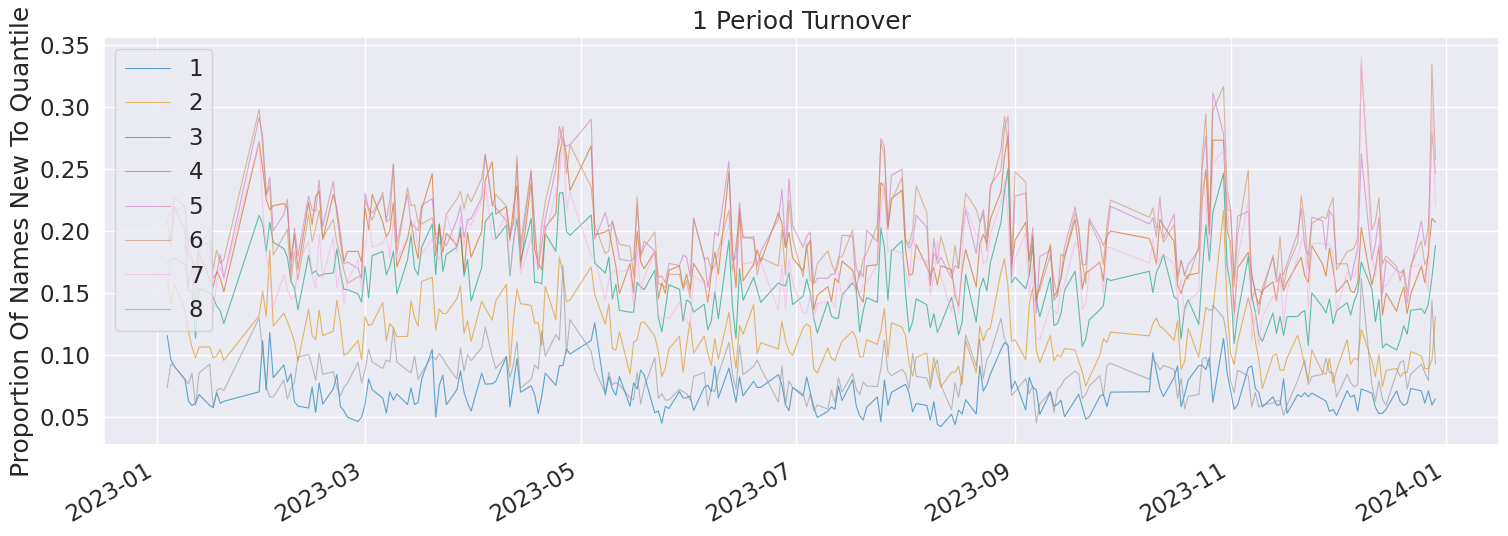

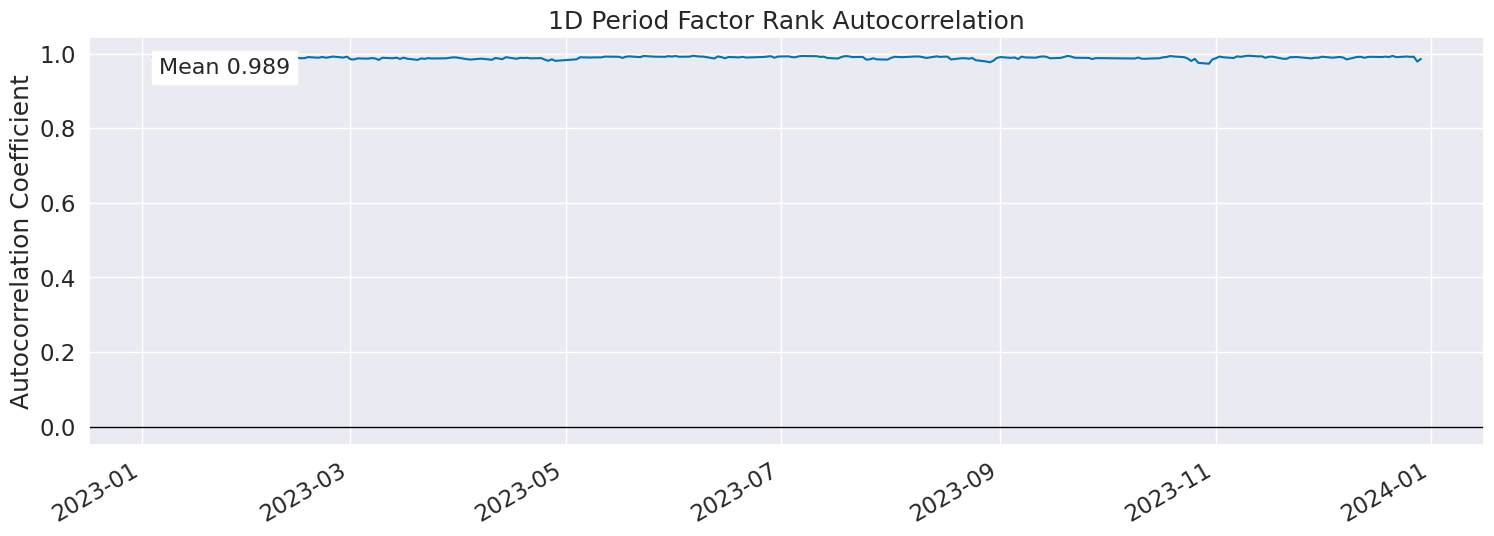

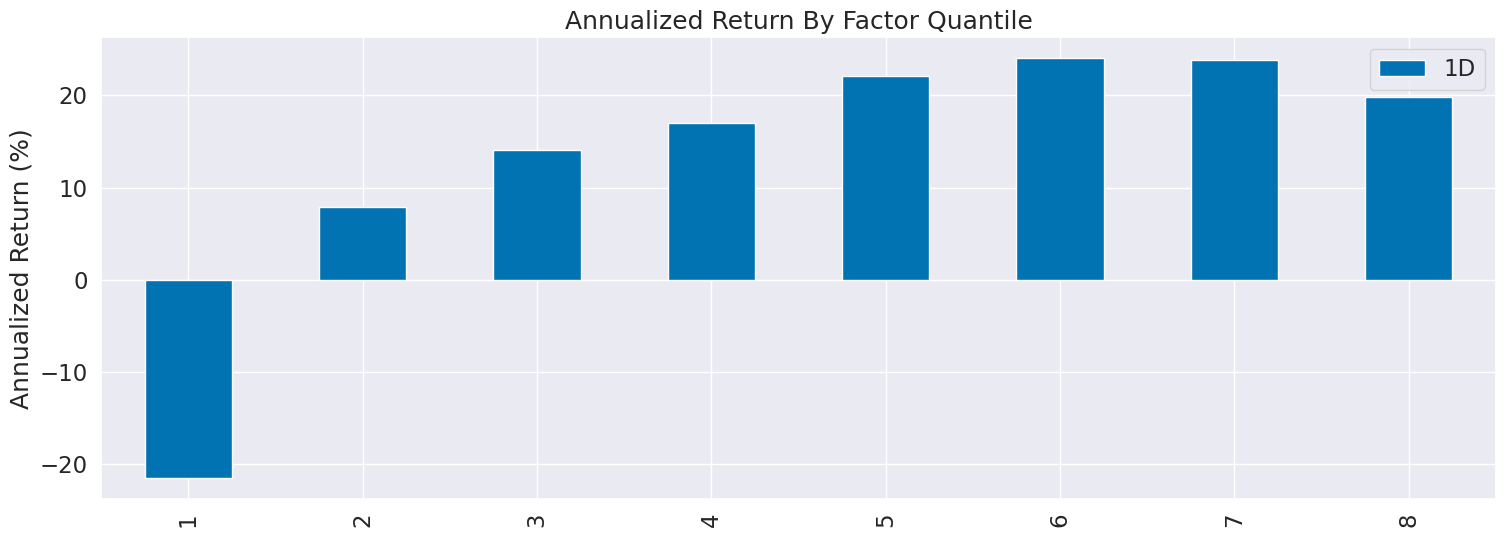

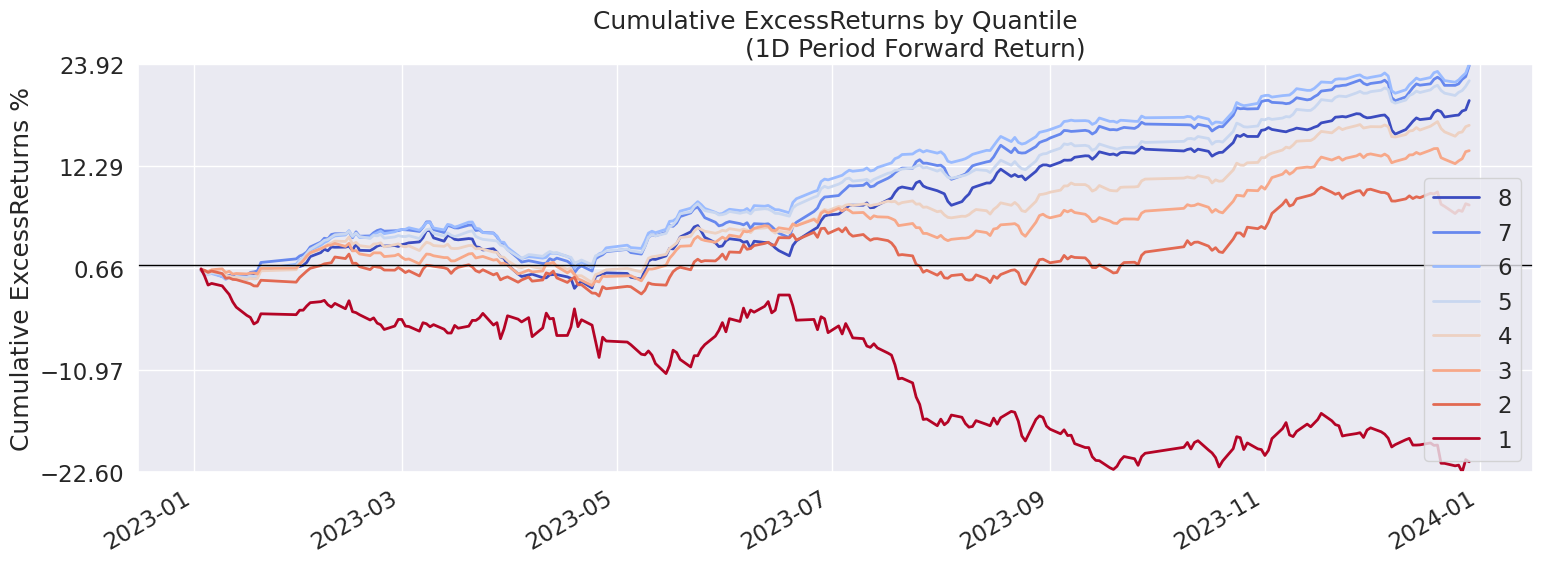

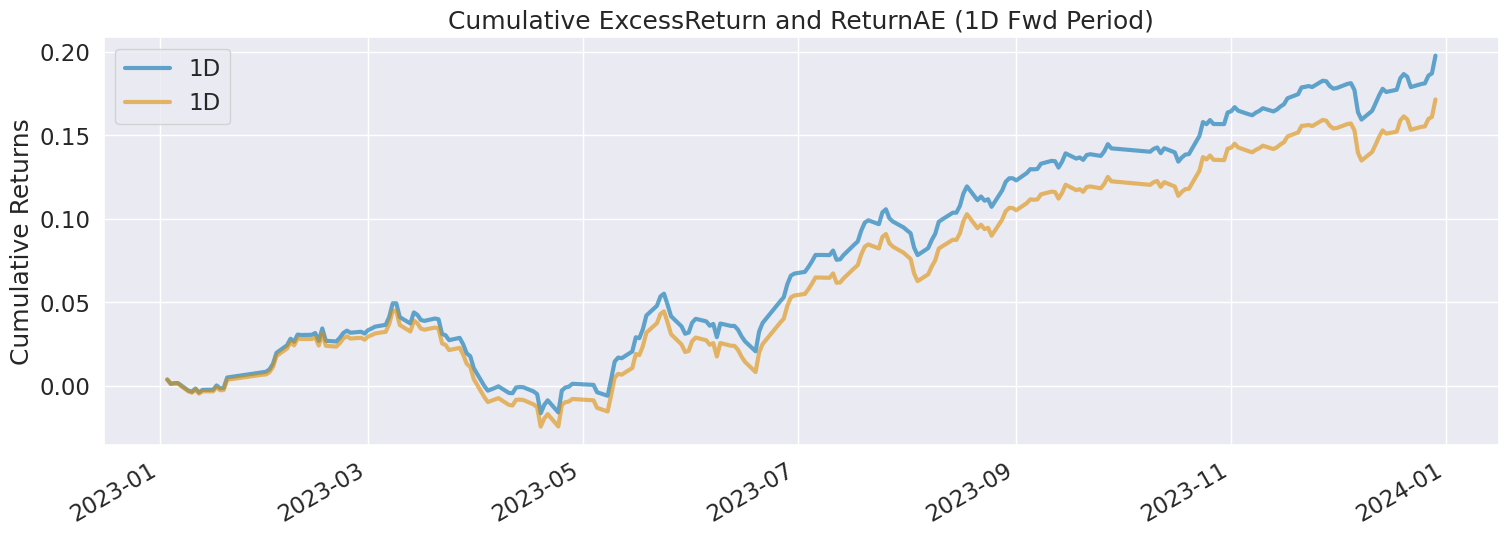

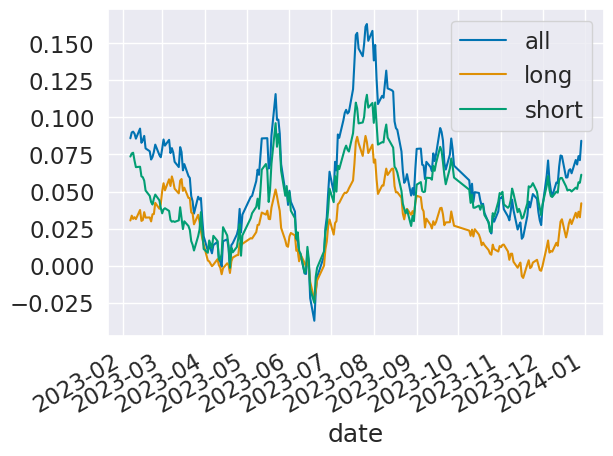

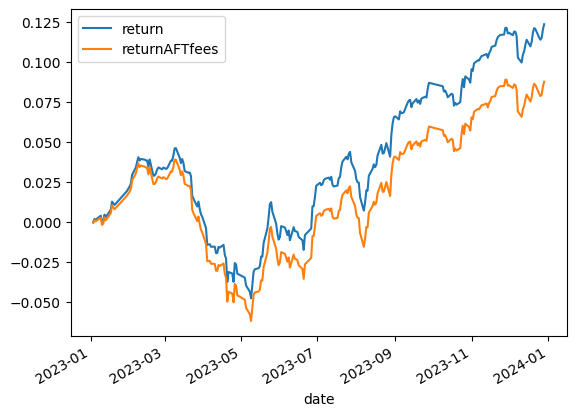

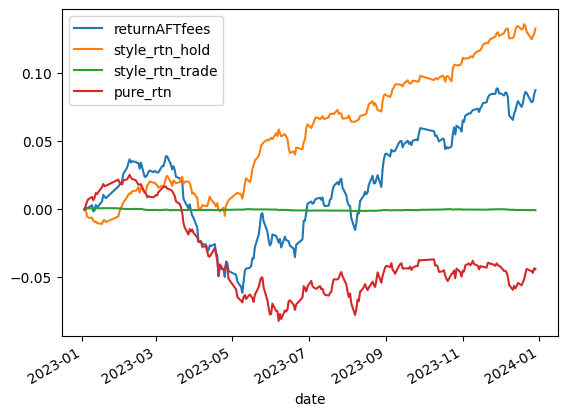

In [21]:
factor = umr_rev()
start_date = pd.to_datetime('2023-01-01')
end_date = pd.to_datetime('2023-12-31')
factor_demo(factor, start_date, end_date, quantiles=8)